In [ ]:
import torch
import numpy as np
import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True  # This will make your experiment slower, but more reproducible


In [3]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy
import numpy as np

import torch
from torchvision import datasets, transforms


# init given linear layer m with given sw and sb
def init_weights(m, sw, sb):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0.0, std=(np.sqrt(sw / m.out_features)))
        nn.init.normal_(m.bias, mean=0.0, std=np.sqrt(sb))

# init new model
# TODO: activation function
# TODO: name the layers
def generate_fc_dnn(input_dim, output_dim, params):
    depth, width = params['depth'], params['width']
    def gen_linear_layer_dim(layer_index):
        return {
            0: (input_dim, width),
            depth - 1: (width, output_dim),
        }.get(layer_index, (width, width))

    fc_list = list()
    for i in range(depth):
        fc_list += [
            nn.Linear(*gen_linear_layer_dim(i)),
            nn.LogSoftmax(dim=1) if (depth - 1 == i) else nn.Tanh()
        ]
    model = nn.Sequential(*fc_list)
    model.apply(lambda m: init_weights(m, params['sw'], params['sb']))
    return model

import torch.nn as nn

class CustomCNN(nn.Module):
    def __init__(self, input_dim, output_dim, depth, num_channels, act_fn, use_pooling=True):
        super(CustomCNN, self).__init__()
        
        in_channels = 1  # Assuming grayscale input images

        for i in range(depth):
            # Add convolutional layer
            setattr(self, f"conv{i}", nn.Conv2d(in_channels, num_channels, kernel_size=3, padding=1))
            
            # Add activation layer
            setattr(self, f"act{i}", act_fn())

            # Add MaxPool2d layer every 2 convolutional layers if use_pooling is set
            if use_pooling and i % 2 == 1:
                setattr(self, f"pool{i}", nn.MaxPool2d(2))
                input_dim = input_dim // 2

            in_channels = num_channels

        flattened_size = in_channels * input_dim * input_dim
        self.fc = nn.Linear(flattened_size, output_dim)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        for layer_name in list(self._modules.keys())[:-2]:  # excluding fc and logsoftmax
            layer = getattr(self, layer_name)
            x = layer(x)
        
        #print(x.size())  # Print the tensor size before flattening
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return self.logsoftmax(x)


def generate_cnn(input_dim, output_dim, depth, num_channels, act_fn=nn.ReLU, use_pooling=True):
    model = CustomCNN(input_dim, output_dim, depth, num_channels, act_fn, use_pooling)
    return model



# dataset_loader is fine-tuning dataset
def eval(model, device, dataset_loader, debug):
    model.eval()
    test_loss, correct = 0., 0.
    with torch.no_grad():
        for data, target in dataset_loader:
            data, target = data.reshape([data.shape[0], -1]).to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(
                output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(
                dim=1,
                keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    num_data = len(dataset_loader.dataset)
    test_loss /= num_data
    acc = correct / num_data
    if debug:
        print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(test_loss, correct, num_data, 100. * acc))

    return acc

# TODO: option to freeze some layers
# TODO: option to save the model?
def compute_training_acc(model, dataset, params, debug=False):
    device = torch.device(params['device'])
    optimizer = optim.SGD(model.parameters(), lr=params['lr'])
    if debug: print(model, optimizer)

    # run training for few steps and return the accuracy
    train_acc = 0.0
    model.train()
    for batch_idx, (data, target) in enumerate(dataset.train_loader):
        data, target = data.reshape([data.shape[0],-1]).to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if debug and batch_idx % 20 == 0:
            print('Train step: {} \tLoss: {:.6f}'.format(
                batch_idx, loss.item()))
        if (batch_idx == params['num_train']):
            train_acc = eval(model, device, dataset.train_loader, debug=False)
            break

    train_acc = eval(model, device, dataset.train_loader, debug=False)
    test_acc = eval(model, device, dataset.test_loader, debug=False)
    return train_acc, test_acc, model

# like previous function, but run for given number of epochs determined by params['num_train']
def compute_training_acc_epochs(model, dataset, params, debug=False):
    print("yo")
    
    device = torch.device(params['device'])
    optimizer = optim.SGD(model.parameters(), lr=params['lr'])
    
    if debug: 
        print(model, optimizer)

    train_acc = 0.0
    model.train()

    # Loop over epochs
    for epoch in range(params['num_train']):
        for batch_idx, (data, target) in enumerate(dataset.train_loader):
            data, target = data.reshape([data.shape[0], -1]).to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            if debug and batch_idx % 20 == 0:
                #print('Epoch: {} Train step: {} \tLoss: {:.6f}'.format(epoch, batch_idx, loss.item()))
                pass

        # Evaluate after each epoch
        if debug:
            train_acc = eval(model, device, dataset.train_loader, debug=False)
            print('Epoch: {} \tTraining Accuracy: {:.2f}%'.format(epoch, train_acc*100))
            # if debug and (epoch+1) % 1 == 0:
            val_acc = eval(model, device, dataset.val_loader, debug=False)
            print('Validation Accuracy: {:.2f}%'.format(val_acc*100))

    # Final evaluation after all epochs are completed
    train_acc = eval(model, device, dataset.train_loader, debug=False)
    test_acc = eval(model, device, dataset.test_loader, debug=False)
    return train_acc, test_acc, model

def eval_cnn(model, device, dataset_loader, debug):
    model.eval()
    test_loss, correct = 0., 0.
    with torch.no_grad():
        for data, target in dataset_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    num_data = len(dataset_loader.dataset)
    test_loss /= num_data
    acc = correct / num_data
    if debug:
        print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, num_data, 100. * acc))

    return acc

def compute_training_acc_epochs_cnn(model, dataset, params, debug=False):
    device = torch.device(params['device'])
    optimizer = optim.SGD(model.parameters(), lr=params['lr'])

    if debug:
        print(model, optimizer)

    # Initialize early stopping variables
    if params.get('early_stop_patience'):
        no_improve_epochs = 0
        max_val_acc = 0.0

    train_acc = 0.0
    model.train()
    checkpoints = []

    # Loop over epochs
    for epoch in range(params['num_train']):
        for batch_idx, (data, target) in enumerate(dataset.train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            if debug and batch_idx % 20 == 0:
                pass

        # Evaluate after each epoch
        if debug:
            train_acc = eval_cnn(model, device, dataset.train_loader, debug=False)
            print('Epoch: {} \tTraining Accuracy: {:.2f}%'.format(epoch, train_acc*100))
            val_acc = eval_cnn(model, device, dataset.val_loader, debug=False)
            print('Validation Accuracy: {:.2f}%'.format(val_acc*100))

            # Early stopping logic
            if params.get('early_stop_patience'):
                if val_acc > max_val_acc:
                    max_val_acc = val_acc
                    no_improve_epochs = 0
                else:
                    no_improve_epochs += 1
                    print("val_acc: {}, max_val_acc: {}, no_improve_epochs: {}".format(val_acc, max_val_acc, no_improve_epochs))
                    if no_improve_epochs >= params['early_stop_patience']:
                        print("Early stopping invoked.")
                        break
        
        # Save checkpoint after each epoch
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_acc': train_acc,
            'val_acc': val_acc
        }
        torch.save(checkpoint, 'checkpoint_epoch_{}.pth'.format(epoch))
        checkpoints.append(checkpoint)

    # Final evaluation after all epochs are completed
    train_acc = eval_cnn(model, device, dataset.train_loader, debug=False)
    test_acc = eval_cnn(model, device, dataset.test_loader, debug=False)
    return train_acc, test_acc, model, checkpoints


# cut_point: no. of layers to keep in the model
# reinitialize after cutting point using init_weights function
def cut_model(model, sw = 1, sb = 1, cut_point=1, freeze=True):
    #deepcopy to avoid changing the original model
    model = copy.deepcopy(model)
    # Convert sequential model to list of layers
    layers = list(model.children())

    # Check if cut_point is out of range
    if cut_point < 0 or cut_point >= len(layers) // 2:
        raise ValueError("cut_point should be in range [0, number of layers - 1]")

    # If freeze is True, set requires_grad to False for layers before cut_point
    if freeze:
        for i in range(cut_point):
            for param in layers[2*i].parameters():
                param.requires_grad = False

    # Cut layers
    new_layers = layers[:2*cut_point]

    # Reinitialize layers after cut point
    for i in range(cut_point, len(layers) // 2):
        linear_layer = layers[2*i]
        activation = layers[2*i + 1]

        # Apply initialization
        init_weights(linear_layer, sw, sb)

        # Append to new layers
        new_layers.extend([linear_layer, activation])

    # Return new model
    return nn.Sequential(*new_layers)

def cut_cnn_model(model, cut_point=1, freeze=True):
    """
    Cut the CNN model at a specific layer and reinitialize the weights for layers after cut_point.

    Parameters:
    - model (nn.Module): Original model.
    - cut_point (int): Layer index at which to cut the model.
    - freeze (bool): If True, layers before cut_point will have their weights frozen.

    Returns:
    - new_model (nn.Sequential): Cut and potentially modified model.
    """
    
    # Deep copy to avoid changing the original model
    model = copy.deepcopy(model)

    # Convert sequential model to list of layers
    layers = list(model.children())

    # Check if cut_point is out of range
    if cut_point < 0 or cut_point >= len(layers):
        raise ValueError("cut_point should be in range [0, number of layers - 1]")

    # If freeze is True, set requires_grad to False for layers before cut_point
    if freeze:
        for i in range(cut_point):
            for param in layers[i].parameters():
                param.requires_grad = False

    # Cut layers
    new_layers = layers[:cut_point]

    # Reinitialize layers after cut point
    for i in range(cut_point, len(layers)):
        layer = layers[i]
        
        # Reinitialize weights if layer has parameters (like Conv2d)
        if hasattr(layer, 'weight'):
            nn.init.kaiming_uniform_(layer.weight, a=0, mode='fan_in', nonlinearity='relu')
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)
        
        # Append to new layers
        new_layers.append(layer)

    # Return new model
    return nn.Sequential(*new_layers)


import copy

def cut_cnn_model_orthogonal(model, cut_point=1, freeze=True):
    """
    Cut the CustomCNN model at a specific layer and reinitialize the weights for layers after cut_point.

    Parameters:
    - model (CustomCNN): Original model.
    - cut_point (int): Layer index at which to cut the model.
    - freeze (bool): If True, layers before cut_point will have their weights frozen.

    Returns:
    - new_model (CustomCNN): Cut and potentially modified model.
    """
    
    # Deep copy to avoid changing the original model
    model = copy.deepcopy(model)

    # Convert modules to a list for ease of access
    layers = list(model.named_children())
    
    current_layer = 0
    for name, layer in layers:
        # Check the type of layer and decide on actions
        if isinstance(layer, nn.Conv2d):
            if current_layer < cut_point:
                if freeze:
                    for param in layer.parameters():
                        param.requires_grad = False
            else:
                # Reinitialize weights for layers after the cut point
                weights_init(layer)
            current_layer += 1

    return model

import torch

def compute_layer_variances(model, test_loader, device='cpu'):
    # Define a hook to collect activations
    activations = {}

    def create_hook(name):
        def hook(module, input, output):
            activations[name] = output
        return hook

    for name, layer in model.named_modules():
        if name:  # this ensures we skip the top-level module (the entire model) which has an empty name
            layer.register_forward_hook(create_hook(name))

    # Run inference on the test set
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)

    # Calculate variance for each layer's activations
    variances = {key: torch.var(act, dim=0) for key, act in activations.items()}
    
    result = {}
    for layer_name, variance in variances.items():
        result[layer_name] = {
            'variance': variance.mean().item(),
            'variance_of_variance': torch.var(variance).item()
        }

    return result, variances



# (1, 28, 28) for CNN
# some people transform it to have 0 mean and 1 std?
class MNISTtrainer(object):
    def __init__(self, batch_size, input_dim=28*28,val_split=0.1):
        self.input_dim = input_dim
        self.output_dim = 10
        self.val_split = val_split

        train = datasets.MNIST(
                '../data',
                train=True,
                download=True,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
                ]))
        
        # split some part of train set to validation
        train_set, val_set = torch.utils.data.random_split(train, [1.-self.val_split, self.val_split])
        self.train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
        self.val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)
        
        self.test_loader = torch.utils.data.DataLoader(
            datasets.MNIST(
                '../data',
                train=False,
                download=True,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
                ])),
            batch_size=batch_size,
            shuffle=True)
        
# (1, 28, 28) for CNN
class FashionMNISTtrainer(object):
    def __init__(self, batch_size, input_dim=28*28, val_split=0.1):
        self.input_dim = input_dim
        self.output_dim = 10
        self.val_split = val_split


        train = datasets.FashionMNIST(
            '../data',
            train=True,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
            ]))
        
        # split some part of train set to validation
        train_set, val_set = torch.utils.data.random_split(train, [1.-self.val_split, self.val_split])
        self.train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
        self.val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

        self.test_loader = torch.utils.data.DataLoader(
            datasets.FashionMNIST(
                '../data',
                train=False,
                download=True,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
                ])),
            batch_size=batch_size,
            shuffle=True)
        


In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import random
import torch.nn.init as init

###############################random seed##############################################################################
manualSeed = random.randint(1, 10000) # fix seed
print("Random Seed: ",manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
#torch.cuda.manual_seed_all(manualSeed)
cudnn.benchmark = True
########################################################################################################################


######################################Generating 2D orthogonal initialization kernel####################################
#generating uniform orthogonal matrix
def _orthogonal_matrix(dim):
    a = torch.zeros((dim, dim)).normal_(0, 1)
    q, r = torch.qr(a)
    d = torch.diag(r, 0).sign()
    diag_size = d.size(0)
    d_exp = d.view(1, diag_size).expand(diag_size, diag_size)
    q.mul_(d_exp)
    return q

#generating orthogonal projection matrix,i.e. the P,Q of Algorithm1 in the original
def _symmetric_projection(n):
    """Compute a n x n symmetric projection matrix.
    Args:
      n: Dimension.
    Returns:
      A n x n orthogonal projection matrix, i.e. a matrix P s.t. P=P*P, P=P^T.
    """
    q = _orthogonal_matrix(n)
    # randomly zeroing out some columns
    # mask = math.cast(random_ops.random_normal([n], seed=self.seed) > 0,
    # #                      self.dtype)
    mask = torch.randn(n)

    c = torch.mul(mask,q)
    U,_,_= torch.svd(c)
    U1 = U[:,0].view(len(U[:,0]),1)
    P = torch.mm(U1,U1.t())
    P_orth_pro_mat = torch.eye(n)-P
    return P_orth_pro_mat

#generating block matrix the step2 of the Algorithm1 in the original
def _block_orth(p1, p2):
    """Construct a 2 x 2 kernel. Used to construct orthgonal kernel.
    Args:
      p1: A symmetric projection matrix (Square).
      p2: A symmetric projection matrix (Square).
    Returns:
      A 2 x 2 kernel [[p1p2,         p1(1-p2)],
                      [(1-p1)p2, (1-p1)(1-p2)]].
    Raises:
      ValueError: If the dimensions of p1 and p2 are different.
    """
    if p1.shape != p2.shape:
        raise ValueError("The dimension of the matrices must be the same.")
    kernel2x2 = {}#Block matrices are contained by a dictionary
    eye = torch.eye(p1.shape[0])
    kernel2x2[0, 0] = torch.mm(p1, p2)
    kernel2x2[0, 1] = torch.mm(p1, (eye - p2))
    kernel2x2[1, 0] = torch.mm((eye - p1), p2)
    kernel2x2[1, 1] = torch.mm((eye - p1), (eye - p2))

    return kernel2x2

#compute convolution operator of equation2.17 in the original
def _matrix_conv(m1, m2):
    """Matrix convolution.
    Args:
      m1: A k x k dictionary, each element is a n x n matrix.
      m2: A l x l dictionary, each element is a n x n matrix.
    Returns:
      (k + l - 1) * (k + l - 1) dictionary each element is a n x n matrix.
    Raises:
      ValueError: if the entries of m1 and m2 are of different dimensions.
    """

    n = m1[0, 0].shape[0]
    if n != m2[0, 0].shape[0]:
        raise ValueError("The entries in matrices m1 and m2 "
                         "must have the same dimensions!")
    k = int(np.sqrt(len(m1)))
    l = int(np.sqrt(len(m2)))
    result = {}
    size = k + l - 1
    # Compute matrix convolution between m1 and m2.
    for i in range(size):
        for j in range(size):
            result[i, j] = torch.zeros(n,n)
            for index1 in range(min(k, i + 1)):
                for index2 in range(min(k, j + 1)):
                    if (i - index1) < l and (j - index2) < l:
                        result[i, j] += torch.mm(m1[index1, index2],
                                                        m2[i - index1, j - index2])
    return result

def _dict_to_tensor(x, k1, k2):
    """Convert a dictionary to a tensor.
    Args:
      x: A k1 * k2 dictionary.
      k1: First dimension of x.
      k2: Second dimension of x.
    Returns:
      A k1 * k2 tensor.
    """
    return torch.stack([torch.stack([x[i, j] for j in range(k2)])
                            for i in range(k1)])

#generating a random 2D orthogonal Convolution kernel
def _orthogonal_kernel(tensor):
    """Construct orthogonal kernel for convolution.
    Args:
      ksize: Kernel size.
      cin: Number of input channels.
      cout: Number of output channels.
    Returns:
      An [ksize, ksize, cin, cout] orthogonal kernel.
    Raises:
      ValueError: If cin > cout.
    """
    ksize = tensor.shape[2]
    cin = tensor.shape[1]
    cout = tensor.shape[0]
    if cin > cout:
        raise ValueError("The number of input channels cannot exceed "
                         "the number of output channels.")
    orth = _orthogonal_matrix(cout)[0:cin, :]#这就是算法1中的H
    if ksize == 1:
        return torch.unsqueeze(torch.unsqueeze(orth,0),0)

    p = _block_orth(_symmetric_projection(cout),
                         _symmetric_projection(cout))
    for _ in range(ksize - 2):
        temp = _block_orth(_symmetric_projection(cout),
                                _symmetric_projection(cout))
        p = _matrix_conv(p, temp)
    for i in range(ksize):
        for j in range(ksize):
            p[i, j] = torch.mm(orth, p[i, j])
    tensor.copy_(_dict_to_tensor(p, ksize, ksize).permute(3,2,1,0))
    return tensor

#defining 2DConvT orthogonal initialization kernel
def ConvT_orth_kernel2D(tensor):
    ksize = tensor.shape[2]
    cin = tensor.shape[0]
    cout = tensor.shape[1]
    if cin > cout:
        raise ValueError("The number of input channels cannot exceed "
                         "the number of output channels.")
    orth = _orthogonal_matrix(cout)[0:cin, :]  # 这就是算法1中的H
    if ksize == 1:
        return torch.unsqueeze(torch.unsqueeze(orth, 0), 0)

    p = _block_orth(_symmetric_projection(cout),
                    _symmetric_projection(cout))
    for _ in range(ksize - 2):
        temp = _block_orth(_symmetric_projection(cout),
                           _symmetric_projection(cout))
        p = _matrix_conv(p, temp)
    for i in range(ksize):
        for j in range(ksize):
            p[i, j] = torch.mm(orth, p[i, j])
    tensor.copy_(_dict_to_tensor(p, ksize, ksize).permute(2, 3, 1, 0))
    return tensor
#Call method
def weights_init(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            if m.weight.shape[0] > m.weight.shape[1]:
                _orthogonal_kernel(m.weight.data)
                m.bias.data.zero_()
            else:
                init.orthogonal(m.weight.data)
                m.bias.data.zero_()

        elif isinstance(m, nn.ConvTranspose2d):
            if m.weight.shape[1] > m.weight.shape[0]:
                ConvT_orth_kernel2D(m.weight.data)
               # m.bias.data.zero_()
            else:
                init.orthogonal(m.weight.data)
               # m.bias.data.zero_()

           # m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            #m.bias.data.zero_()
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.zero_()
'''
Algorithm requires The number of input channels cannot exceed the number of output channels.
 However, some questions may be in_channels>out_channels. 
 For example, the final dense layer in GAN. If counters this case, Orthogonal_kernel is replaced by the common orthogonal init'''
'''
for example,
net=nn.Conv2d(3,64,3,2,1)
net.apply(Conv2d_weights_orth_init)
'''

def makeDeltaOrthogonal(in_channels=3, out_channels=64, kernel_size=3, gain=torch.Tensor([1])):
    weights = torch.zeros(out_channels, in_channels, kernel_size, kernel_size)
    out_channels = weights.size(0)
    in_channels = weights.size(1)
    if weights.size(1) > weights.size(0):
        raise ValueError("In_filters cannot be greater than out_filters.")
    q = _orthogonal_matrix(out_channels)
    q = q[:in_channels, :]
    q *= torch.sqrt(gain)
    beta1 = weights.size(2) // 2
    beta2 = weights.size(3) // 2
    weights[:, :, beta1, beta2] = q
    return weights
#Calling method is the same as the above _orthogonal_kernel
######################################################END###############################################################


Random Seed:  1825


### Baseline, end to end trained model

/tmp/ipykernel_28/3619457995.py:181: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  init.orthogonal(m.weight.data)


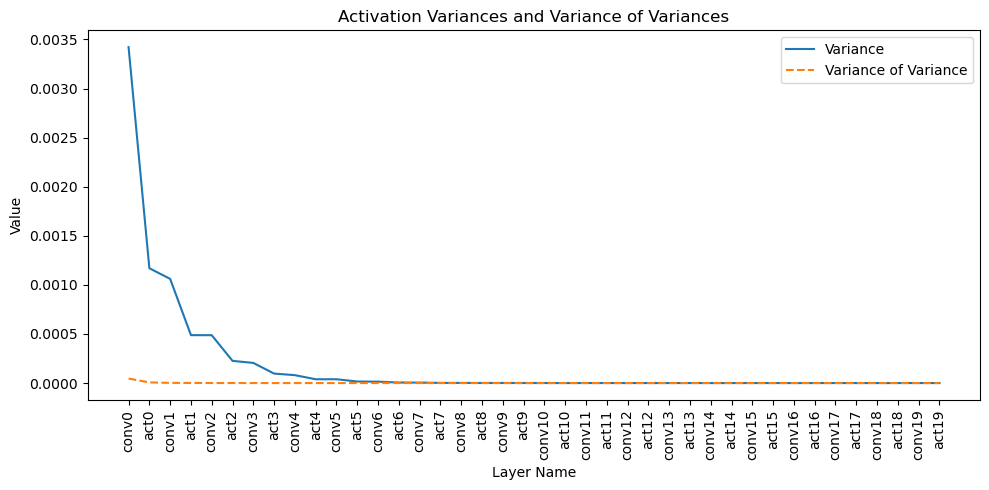

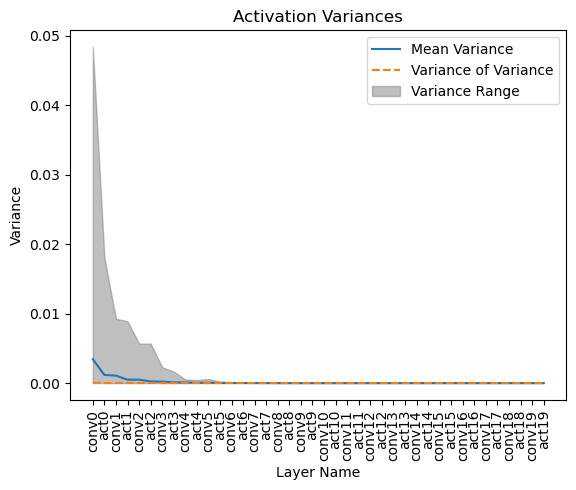

In [7]:
batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
depth = 20

#TODO: the CNN code does not initialize the weights with sw and sb
fashion_dataset = FashionMNISTtrainer(batch_size, input_dim = (1,28,28))
params = dict(device=device,
                width=25, lr=0.01, num_train=10, depth= depth, early_stop_patience= 2)

fashion_model = generate_cnn(fashion_dataset.input_dim[1], fashion_dataset.output_dim,
                params['depth'], params['width'], act_fn=nn.ReLU, use_pooling=False).to(device)

fashion_model.apply(weights_init)

results, variances = compute_layer_variances(fashion_model, fashion_dataset.train_loader, device = 'cuda')

import matplotlib.pyplot as plt

# Create a list of layer names and variances
layer_names = list(variances.keys())
variance_values = [variance.mean().item() for variance in variances.values()]
variance_of_variance_values = [results[layer]['variance_of_variance'] for layer in layer_names]

# Plot the variances
plt.figure(figsize=(10, 5))
plt.plot(layer_names[:-2], variance_values[:-2], label='Variance')
plt.plot(layer_names[:-2], variance_of_variance_values[:-2], label='Variance of Variance', linestyle='--')
plt.xticks(rotation=90)
plt.xlabel('Layer Name')
plt.ylabel('Value')
plt.title('Activation Variances and Variance of Variances')
plt.legend()
plt.tight_layout()
plt.show()

# Create lists for mean, min, and max variance for each layer
layer_names = list(variances.keys())
mean_variances = [variance.mean().item() for variance in variances.values()]
min_variances = [variance.min().item() for variance in variances.values()]
max_variances = [variance.max().item() for variance in variances.values()]

# Plot the variances
plt.plot(layer_names[:-2], mean_variances[:-2], label='Mean Variance')
plt.plot(layer_names[:-2], variance_of_variance_values[:-2], label='Variance of Variance', linestyle='--')

# Shade the region between the min and max variance
plt.fill_between(layer_names[:-2], min_variances[:-2], max_variances[:-2], color='gray', alpha=0.5, label='Variance Range')

plt.xticks(rotation=90)
plt.xlabel('Layer Name')
plt.ylabel('Variance')
plt.title('Activation Variances')
plt.legend()
plt.show()


In [8]:
train_acc, test_acc, pretrained_model, check = compute_training_acc_epochs_cnn(fashion_model, fashion_dataset, params, debug=True)

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

In [13]:
# Save model state dictionary
torch.save(fashion_model.state_dict(), "pretrained_fashion_model_20_25.pth")
torch.save(checkpoints, 'pretrained_fashion_model_20_25_checkpoints.pth')


In [6]:
batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
depth = 20


#TODO: the CNN code does not initialize the weights with sw and sb
fashion_dataset = FashionMNISTtrainer(batch_size, input_dim = (1,28,28))
params = dict(device=device,
                width=25, lr=0.01, num_train=10, depth= depth, early_stop_patience= 2)

fashion_model = generate_cnn(fashion_dataset.input_dim[1], fashion_dataset.output_dim,
                params['depth'], params['width'], act_fn=nn.ReLU, use_pooling=False).to(device)
# Initialize the model structure (you should have the same model structure as the one you saved)
fashion_model = generate_cnn(fashion_dataset.input_dim[1], fashion_dataset.output_dim,
                params['depth'], params['width'], act_fn=nn.ReLU, use_pooling=False).to(device)

# Load the model state dictionary
fashion_model.load_state_dict(torch.load("/kaggle/input/cnn-finetuning-experiment/pretrained_fashion_model_20_25.pth"))

# Set the model to evaluation mode (important for models with dropout, batchnorm, etc.)
fashion_model.eval()


CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

In [7]:
# Usage:
results, variances = compute_layer_variances(fashion_model, fashion_dataset.train_loader, device = 'cuda')
for layer_name, stats in results.items():
    print(f"Layer {layer_name} - Variance: {stats['variance']}, Variance of Variance: {stats['variance_of_variance']}")


Layer conv0 - Variance: 0.00724944518879056, Variance of Variance: 0.00013292265066411346
Layer act0 - Variance: 0.0012305608252063394, Variance of Variance: 5.6431390476063825e-06
Layer conv1 - Variance: 0.00236625992693007, Variance of Variance: 9.042134479386732e-06
Layer act1 - Variance: 0.0012026571203023195, Variance of Variance: 5.7016050050151534e-06
Layer conv2 - Variance: 0.002985747531056404, Variance of Variance: 2.6302561309421435e-05
Layer act2 - Variance: 0.0023761214688420296, Variance of Variance: 2.715655318752397e-05
Layer conv3 - Variance: 0.007033825386315584, Variance of Variance: 0.00018935829575639218
Layer act3 - Variance: 0.005714318715035915, Variance of Variance: 0.0001976042694877833
Layer conv4 - Variance: 0.015338378958404064, Variance of Variance: 0.0007933704764582217
Layer act4 - Variance: 0.01299835555255413, Variance of Variance: 0.0008308353717438877
Layer conv5 - Variance: 0.03512789309024811, Variance of Variance: 0.004029625095427036
Layer act5 -

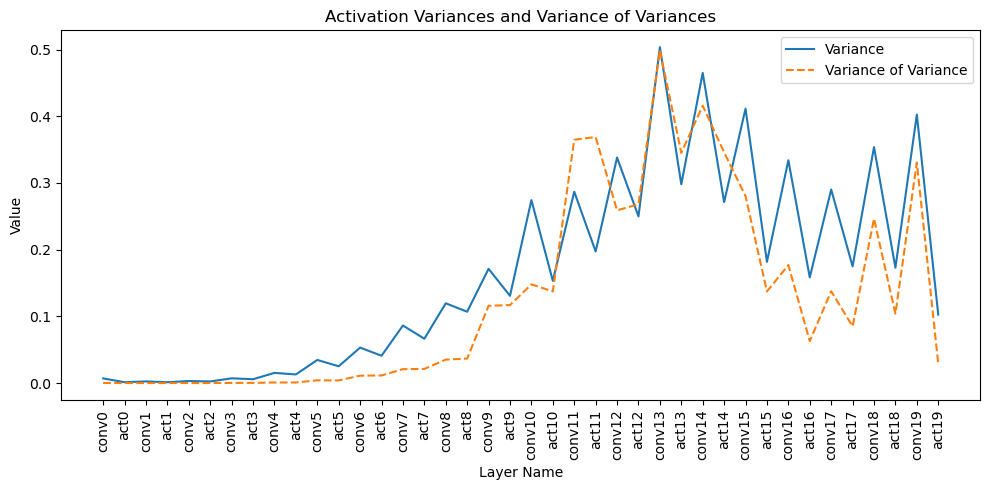

In [15]:
import matplotlib.pyplot as plt

# Create a list of layer names and variances
layer_names = list(variances.keys())
variance_values = [variance.mean().item() for variance in variances.values()]
variance_of_variance_values = [results[layer]['variance_of_variance'] for layer in layer_names]

# Plot the variances
plt.figure(figsize=(10, 5))
plt.plot(layer_names[:-2], variance_values[:-2], label='Variance')
plt.plot(layer_names[:-2], variance_of_variance_values[:-2], label='Variance of Variance', linestyle='--')
plt.xticks(rotation=90)
plt.xlabel('Layer Name')
plt.ylabel('Value')
plt.title('Activation Variances and Variance of Variances')
plt.legend()
plt.tight_layout()
plt.show()


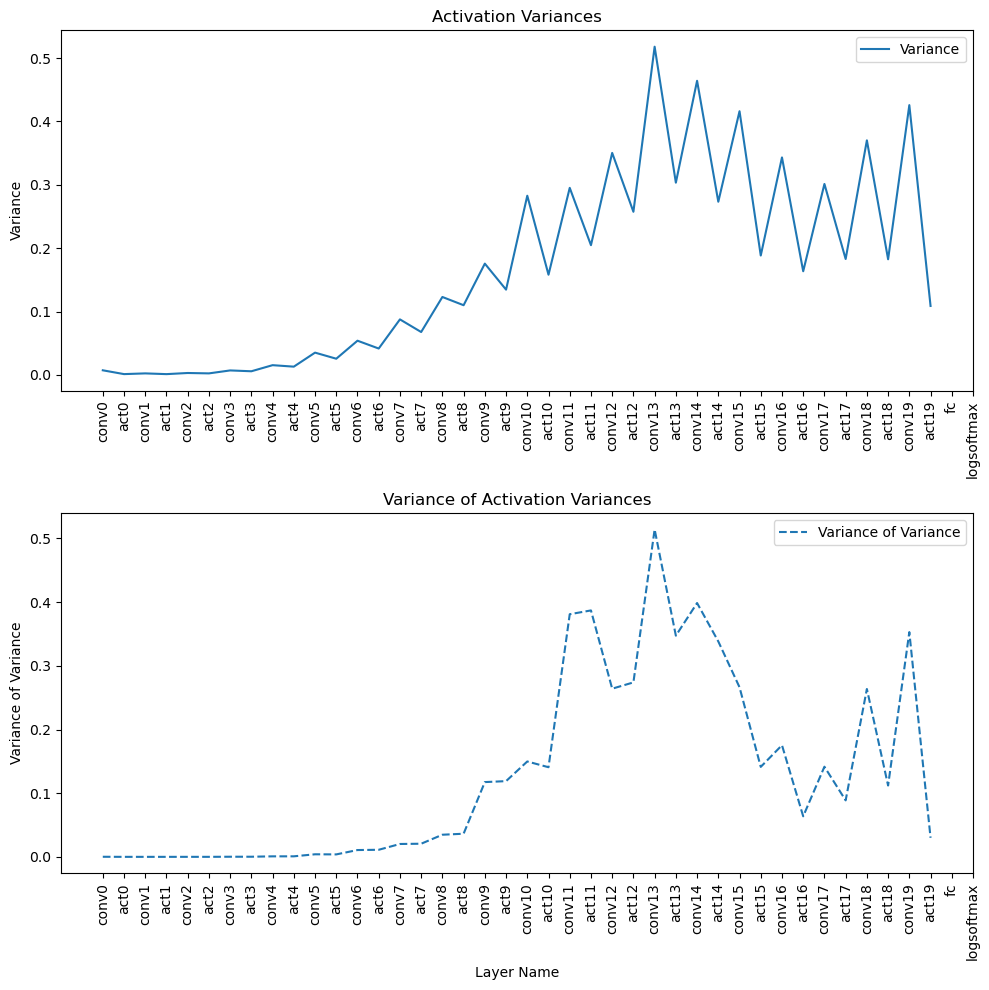

In [8]:
import matplotlib.pyplot as plt

# Create a list of layer names and variances
layer_names = list(variances.keys())
variance_values = [variance.mean().item() for variance in variances.values()]
variance_of_variance_values = [results[layer]['variance_of_variance'] for layer in layer_names]

fig, axarr = plt.subplots(2, 1, figsize=(10, 10))

# Plot the variances on the first row
axarr[0].plot(layer_names[:-2], variance_values[:-2], label='Variance')
axarr[0].set_xticks(layer_names)
axarr[0].set_xticklabels(layer_names, rotation=90)
axarr[0].set_ylabel('Variance')
axarr[0].set_title('Activation Variances')
axarr[0].legend()

# Plot the variance of variances on the second row
axarr[1].plot(layer_names[:-2], variance_of_variance_values[:-2], label='Variance of Variance', linestyle='--')
axarr[1].set_xticks(layer_names)
axarr[1].set_xticklabels(layer_names, rotation=90)
axarr[1].set_xlabel('Layer Name')
axarr[1].set_ylabel('Variance of Variance')
axarr[1].set_title('Variance of Activation Variances')
axarr[1].legend()

plt.tight_layout()
plt.show()


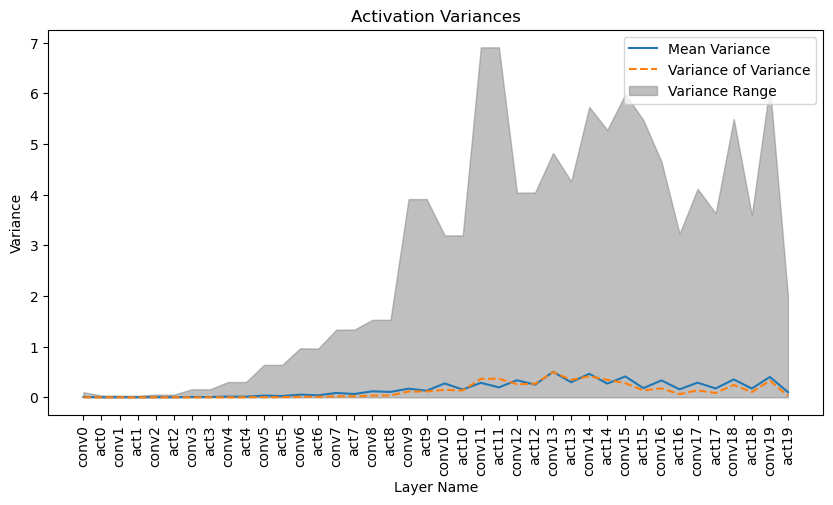

In [17]:
# Create lists for mean, min, and max variance for each layer
layer_names = list(variances.keys())
mean_variances = [variance.mean().item() for variance in variances.values()]
min_variances = [variance.min().item() for variance in variances.values()]
max_variances = [variance.max().item() for variance in variances.values()]

plt.figure(figsize=(10, 5))
# Plot the variances
plt.plot(layer_names[:-2], mean_variances[:-2], label='Mean Variance')
plt.plot(layer_names[:-2], variance_of_variance_values[:-2], label='Variance of Variance', linestyle='--')

# Shade the region between the min and max variance
plt.fill_between(layer_names[:-2], min_variances[:-2], max_variances[:-2], color='gray', alpha=0.5, label='Variance Range')

plt.xticks(rotation=90)
plt.xlabel('Layer Name')
plt.ylabel('Variance')
plt.title('Activation Variances')
plt.legend()
plt.show()


/tmp/ipykernel_28/2679474638.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(conv_layer_names, rotation=90)
/tmp/ipykernel_28/2679474638.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(activation_layer_names, rotation=90)


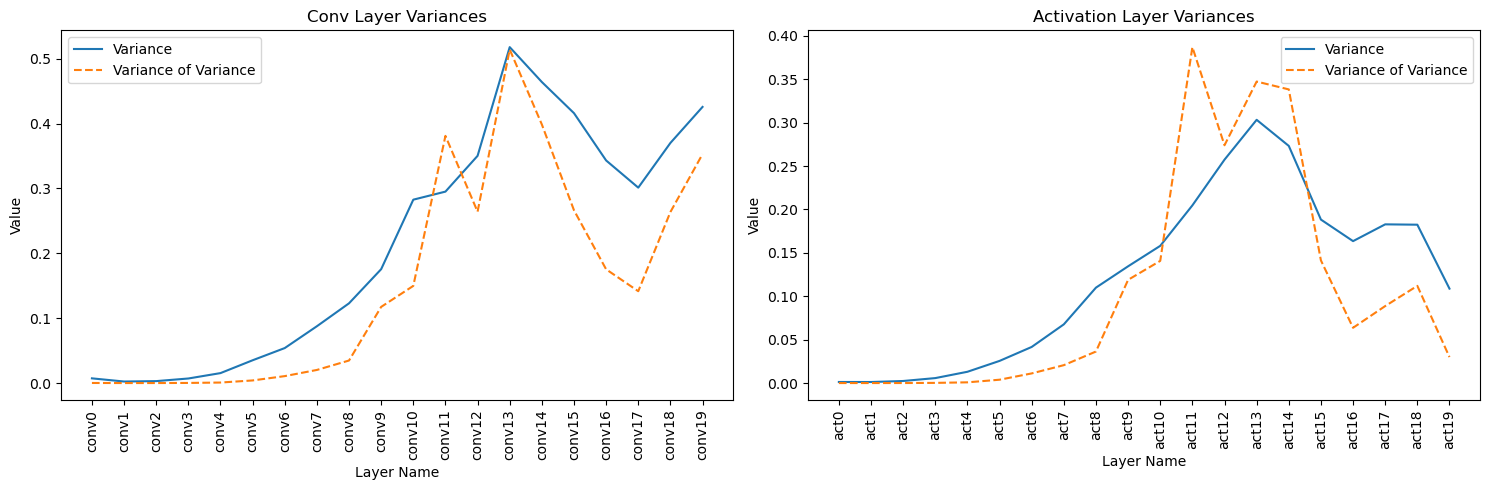

In [9]:
# Create a list of layer names and variances for fc layers
conv_layer_names = [name for name in variances.keys() if 'conv' in name]
conv_variance_values = [variance.mean().item() for name, variance in variances.items() if 'conv' in name]

# Create a list of layer names and variances for activation layers
activation_layer_names = [name for name in variances.keys() if 'act' in name]
activation_variance_values = [variance.mean().item() for name, variance in variances.items() if 'act' in name]

# Create a list of layer names and variances for pool layers
pool_layer_names = [name for name in variances.keys() if 'pool' in name]
pool_variance_values = [variance.mean().item() for name, variance in variances.items() if 'pool' in name]

# Extract variance of variance values
conv_variance_of_variance_values = [results[name]['variance_of_variance'] for name in conv_layer_names]
activation_variance_of_variance_values = [results[name]['variance_of_variance'] for name in activation_layer_names]
pool_variance_of_variance_values = [results[name]['variance_of_variance'] for name in pool_layer_names]

# Create a figure with three subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the variances and variance of variances for conv layers
axs[0].plot(conv_layer_names, conv_variance_values, label='Variance')
axs[0].plot(conv_layer_names, conv_variance_of_variance_values, linestyle='--', label='Variance of Variance')
axs[0].set_xticklabels(conv_layer_names, rotation=90)
axs[0].set_xlabel('Layer Name')
axs[0].set_ylabel('Value')
axs[0].set_title('Conv Layer Variances')
axs[0].legend()

# Plot the variances and variance of variances for activation layers
axs[1].plot(activation_layer_names, activation_variance_values, label='Variance')
axs[1].plot(activation_layer_names, activation_variance_of_variance_values, linestyle='--', label='Variance of Variance')
axs[1].set_xticklabels(activation_layer_names, rotation=90)
axs[1].set_xlabel('Layer Name')
axs[1].set_ylabel('Value')
axs[1].set_title('Activation Layer Variances')
axs[1].legend()

'''# Plot the variances and variance of variances for pool layers
axs[2].plot(pool_layer_names, pool_variance_values, label='Variance')
axs[2].plot(pool_layer_names, pool_variance_of_variance_values, linestyle='--', label='Variance of Variance')
axs[2].set_xticklabels(pool_layer_names, rotation=90)
axs[2].set_xlabel('Layer Name')
axs[2].set_ylabel('Value')
axs[2].set_title('Pool Layer Variances')
axs[2].legend()'''

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


/tmp/ipykernel_28/663320863.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(conv_layer_names, rotation=90)
/tmp/ipykernel_28/663320863.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(activation_layer_names, rotation=90)


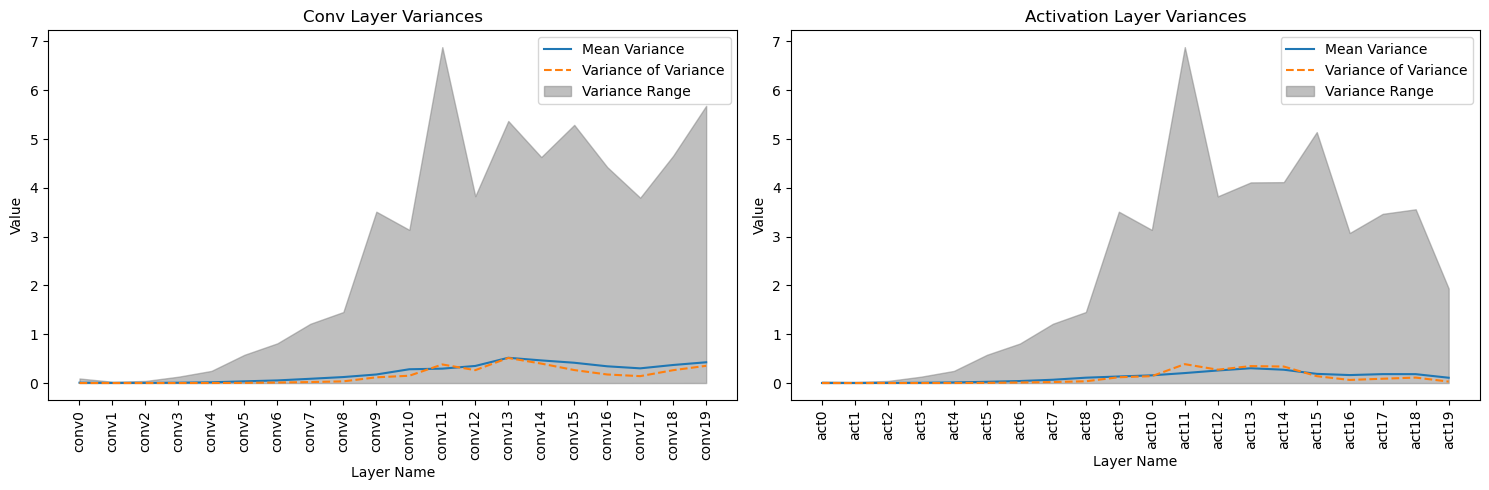

In [11]:
# Create lists for mean, min, and max variance for each type of layer
def extract_variances_from_names(names, variances):
    mean_vals = [variances[name].mean().item() for name in names]
    min_vals = [variances[name].min().item() for name in names]
    max_vals = [variances[name].max().item() for name in names]
    return mean_vals, min_vals, max_vals

conv_mean, conv_min, conv_max = extract_variances_from_names(conv_layer_names, variances)
activation_mean, activation_min, activation_max = extract_variances_from_names(activation_layer_names, variances)
pool_mean, pool_min, pool_max = extract_variances_from_names(pool_layer_names, variances)

def extract_variance_of_variance_from_names(names, results):
    return [results[name]['variance_of_variance'] for name in names]

conv_vov = extract_variance_of_variance_from_names(conv_layer_names, results)
activation_vov = extract_variance_of_variance_from_names(activation_layer_names, results)
pool_vov = extract_variance_of_variance_from_names(pool_layer_names, results)

# Create a figure with three subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the variances for conv layers
axs[0].plot(conv_layer_names, conv_mean, label='Mean Variance')
axs[0].plot(conv_layer_names, conv_vov, linestyle='--', label='Variance of Variance')
axs[0].fill_between(conv_layer_names, conv_min, conv_max, color='gray', alpha=0.5, label='Variance Range')
axs[0].set_xticklabels(conv_layer_names, rotation=90)
axs[0].set_xlabel('Layer Name')
axs[0].set_ylabel('Value')
axs[0].set_title('Conv Layer Variances')
axs[0].legend()

# Plot the variances for activation layers
axs[1].plot(activation_layer_names, activation_mean, label='Mean Variance')
axs[1].plot(activation_layer_names, activation_vov, linestyle='--', label='Variance of Variance')
axs[1].fill_between(activation_layer_names, activation_min, activation_max, color='gray', alpha=0.5, label='Variance Range')
axs[1].set_xticklabels(activation_layer_names, rotation=90)
axs[1].set_xlabel('Layer Name')
axs[1].set_ylabel('Value')
axs[1].set_title('Activation Layer Variances')
axs[1].legend()

'''# Plot the variances for pool layers
axs[2].plot(pool_layer_names, pool_mean, label='Mean Variance')
axs[2].plot(pool_layer_names, pool_vov, linestyle='--', label='Variance of Variance')
axs[2].fill_between(pool_layer_names, pool_min, pool_max, color='gray', alpha=0.5, label='Variance Range')
axs[2].set_xticklabels(pool_layer_names, rotation=90)
axs[2].set_xlabel('Layer Name')
axs[2].set_ylabel('Value')
axs[2].set_title('Pool Layer Variances')
axs[2].legend()'''

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


In [13]:
checkpoints = loaded_experiments = torch.load('/kaggle/input/cnn-finetuning-experiment/pretrained_fashion_model_20_25_checkpoints.pth')


/tmp/ipykernel_28/2513496950.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[idx + 1, 0].set_xticklabels(conv_layer_names, rotation=90)
/tmp/ipykernel_28/2513496950.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[idx + 1, 1].set_xticklabels(activation_layer_names, rotation=90)


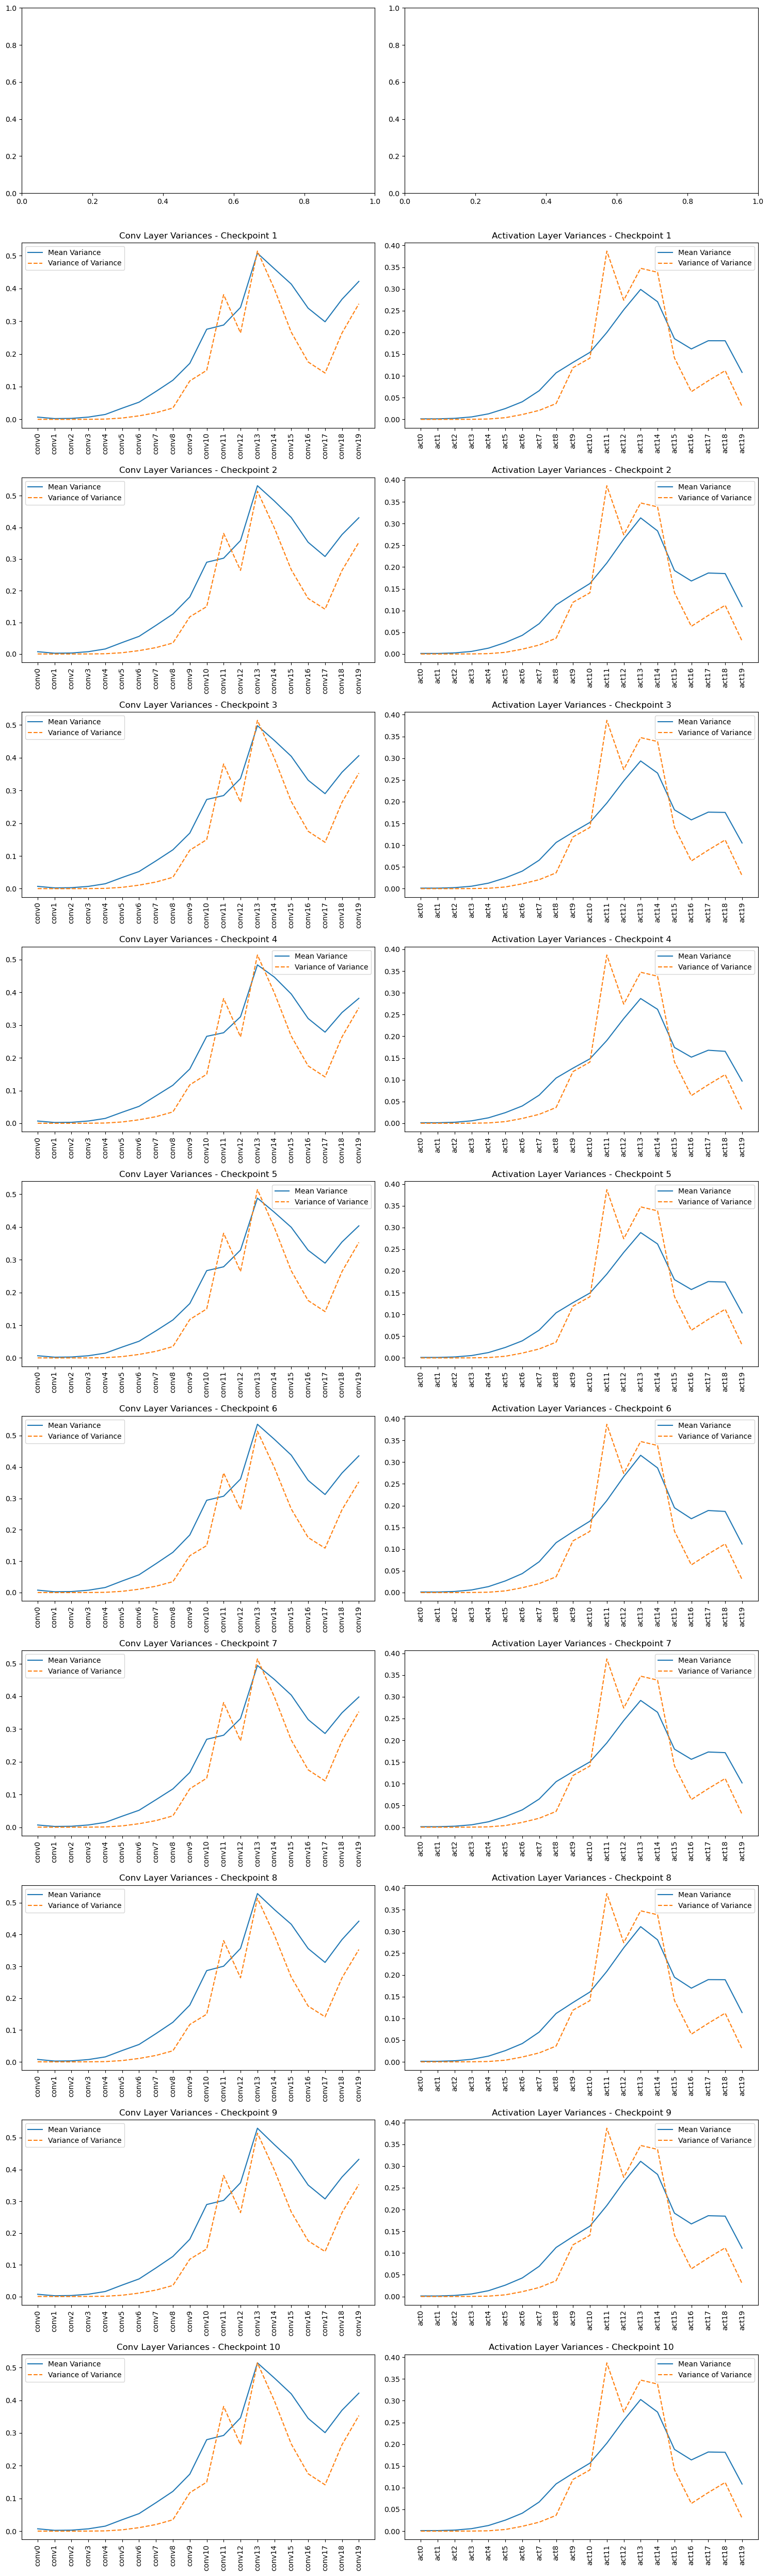

In [14]:
# Assuming your model and dataset variables are already defined
num_checkpoints = len(checkpoints)

# Create a function to extract variance of variances:
def extract_variance_of_variance_from_names(names, results):
    return [results[name]['variance_of_variance'] for name in names]

# Create a figure with an additional row for each checkpoint
fig, axs = plt.subplots(num_checkpoints + 1, 2, figsize=(15, 5 * (num_checkpoints + 1)))

# Your original plotting code (for the baseline model) goes here...

model = generate_cnn(fashion_dataset.input_dim[1], fashion_dataset.output_dim,
                params['depth'], params['width'], act_fn=nn.ReLU, use_pooling=False).to(device)

# Now, loop through the checkpoints
for idx, checkpoint in enumerate(checkpoints):
    # Load model state_dict from checkpoint
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Compute the layer variances for the checkpointed model
    _, variances_checkpoint = compute_layer_variances(model, fashion_dataset.train_loader, device='cuda')

    # Extract variances and variance of variances for each type of layer
    conv_mean, conv_min, conv_max = extract_variances_from_names(conv_layer_names, variances_checkpoint)
    conv_vov = extract_variance_of_variance_from_names(conv_layer_names, results)
    activation_mean, activation_min, activation_max = extract_variances_from_names(activation_layer_names, variances_checkpoint)
    activation_vov = extract_variance_of_variance_from_names(activation_layer_names, results)
    pool_mean, pool_min, pool_max = extract_variances_from_names(pool_layer_names, variances_checkpoint)
    pool_vov = extract_variance_of_variance_from_names(pool_layer_names, results)
    
    # Plot variances for conv layers
    axs[idx + 1, 0].plot(conv_layer_names, conv_mean, label='Mean Variance')
    axs[idx + 1, 0].plot(conv_layer_names, conv_vov, linestyle='--', label='Variance of Variance')
    #axs[idx + 1, 0].fill_between(conv_layer_names, conv_min, conv_max, color='gray', alpha=0.5, label='Variance Range')
    axs[idx + 1, 0].set_xticklabels(conv_layer_names, rotation=90)
    axs[idx + 1, 0].set_title(f'Conv Layer Variances - Checkpoint {idx + 1}')
    axs[idx + 1, 0].legend()

    # Plot variances for activation layers
    axs[idx + 1, 1].plot(activation_layer_names, activation_mean, label='Mean Variance')
    axs[idx + 1, 1].plot(activation_layer_names, activation_vov, linestyle='--', label='Variance of Variance')
    #axs[idx + 1, 1].fill_between(activation_layer_names, activation_min, activation_max, color='gray', alpha=0.5, label='Variance Range')
    axs[idx + 1, 1].set_xticklabels(activation_layer_names, rotation=90)
    axs[idx + 1, 1].set_title(f'Activation Layer Variances - Checkpoint {idx + 1}')
    axs[idx + 1, 1].legend()

    '''# Plot variances for pool layers
    axs[idx + 1, 2].plot(pool_layer_names, pool_mean, label='Mean Variance')
    axs[idx + 1, 2].plot(pool_layer_names, pool_vov, linestyle='--', label='Variance of Variance')
    axs[idx + 1, 2].fill_between(pool_layer_names, pool_min, pool_max, color='gray', alpha=0.5, label='Variance Range')
    axs[idx + 1, 2].set_xticklabels(pool_layer_names, rotation=90)
    axs[idx + 1, 2].set_title(f'Pool Layer Variances - Checkpoint {idx + 1}')
    axs[idx + 1, 2].legend()'''

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


### finetuned staring from fashion mnist to number mnist

In [48]:
params = dict(device=device,
                width=25, lr=0.01, num_train=4, depth= depth, early_stop_patience= 3)

#luckily, the number of classes is the same, so we don't need to change the last layer.

number_dataset = MNISTtrainer(batch_size, input_dim = (1,28,28))

100%|██████████| 9912422/9912422 [00:00<00:00, 116155334.66it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 61835474.13it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31060880.45it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10536796.88it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [18]:
from tqdm import tqdm

cut_models = []

for cut in tqdm(range(depth)):
    temp = {}
    temp['cut_model'] = cut_cnn_model_orthogonal(fashion_model, cut_point = cut, freeze = True)
    finetuned_acc, finetuned_test_acc, finetuned_model = compute_training_acc_epochs_cnn(temp['cut_model'], number_dataset, params, debug=False)
    temp['finetuned_acc'] = finetuned_acc
    temp['finetuned_test_acc'] = finetuned_test_acc
    temp['finetuned_model'] = finetuned_model
    cut_models.append(temp)   

  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_28/3619457995.py:181: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  init.orthogonal(m.weight.data)
100%|██████████| 20/20 [16:52<00:00, 50.64s/it]


Layer conv0 - Variance: {'variance': 0.006312573328614235, 'variance_of_variance': 0.00020062825933564454}
Layer act0 - Variance: {'variance': 0.0011744353687390685, 'variance_of_variance': 9.292358299717307e-06}
Layer conv1 - Variance: {'variance': 0.0021284653339535, 'variance_of_variance': 1.4640369954577181e-05}
Layer act1 - Variance: {'variance': 0.0010552966268733144, 'variance_of_variance': 8.144543244270608e-06}
Layer conv2 - Variance: {'variance': 0.0023912026081234217, 'variance_of_variance': 2.5993886083597317e-05}
Layer act2 - Variance: {'variance': 0.0018356202635914087, 'variance_of_variance': 2.5320196073153056e-05}
Layer conv3 - Variance: {'variance': 0.005047151818871498, 'variance_of_variance': 0.00013913634757045656}
Layer act3 - Variance: {'variance': 0.003930657636374235, 'variance_of_variance': 0.0001400420442223549}
Layer conv4 - Variance: {'variance': 0.009981034323573112, 'variance_of_variance': 0.0004907514667138457}
Layer act4 - Variance: {'variance': 0.00825

/tmp/ipykernel_28/3252709731.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(conv_layer_names, rotation=90)
/tmp/ipykernel_28/3252709731.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(activation_layer_names, rotation=90)


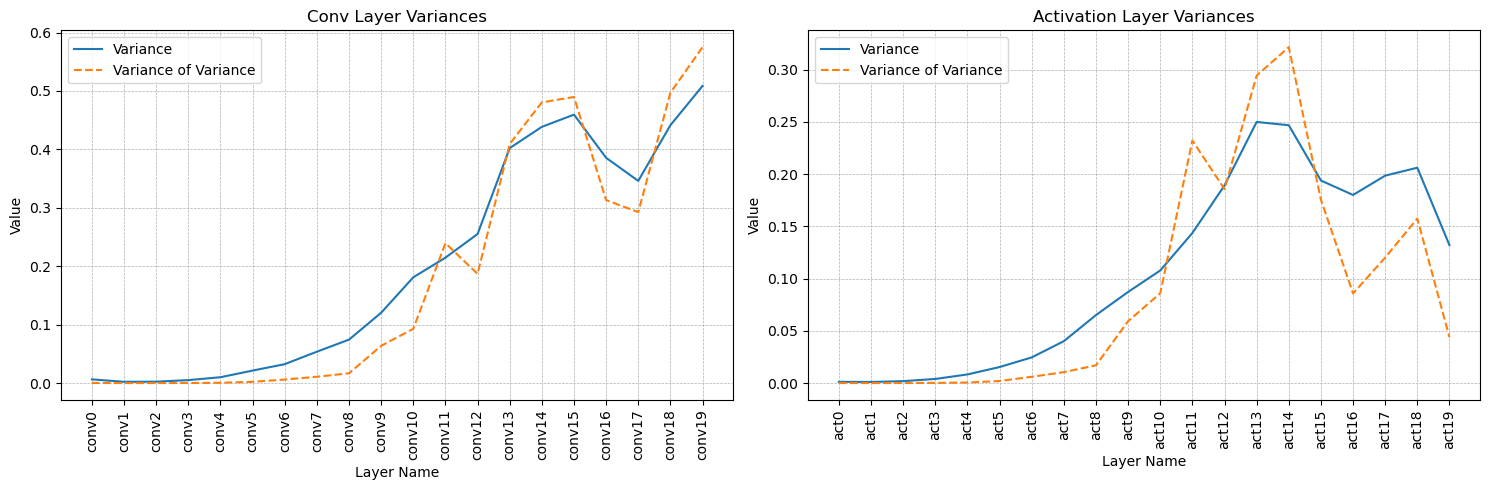

In [50]:
results, variances = compute_layer_variances(fashion_model, number_dataset.train_loader, device = 'cuda')
for layer_name, variance in results.items():
    print(f"Layer {layer_name} - Variance: {variance}")

# Create a list of layer names and variances for fc layers
conv_layer_names = [name for name in variances.keys() if 'conv' in name]
conv_variance_values = [variance.mean().item() for name, variance in variances.items() if 'conv' in name]

# Create a list of layer names and variances for activation layers
activation_layer_names = [name for name in variances.keys() if 'act' in name]
activation_variance_values = [variance.mean().item() for name, variance in variances.items() if 'act' in name]

# Create a list of layer names and variances for pool layers
pool_layer_names = [name for name in variances.keys() if 'pool' in name]
pool_variance_values = [variance.mean().item() for name, variance in variances.items() if 'pool' in name]

# Extract variance of variance values
conv_variance_of_variance_values = [results[name]['variance_of_variance'] for name in conv_layer_names]
activation_variance_of_variance_values = [results[name]['variance_of_variance'] for name in activation_layer_names]
pool_variance_of_variance_values = [results[name]['variance_of_variance'] for name in pool_layer_names]

# Create a figure with three subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the variances and variance of variances for conv layers
axs[0].plot(conv_layer_names, conv_variance_values, label='Variance')
axs[0].plot(conv_layer_names, conv_variance_of_variance_values, linestyle='--', label='Variance of Variance')
axs[0].set_xticklabels(conv_layer_names, rotation=90)
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)
axs[0].set_xlabel('Layer Name')
axs[0].set_ylabel('Value')
axs[0].set_title('Conv Layer Variances')
axs[0].legend()

# Plot the variances and variance of variances for activation layers
axs[1].plot(activation_layer_names, activation_variance_values, label='Variance')
axs[1].plot(activation_layer_names, activation_variance_of_variance_values, linestyle='--', label='Variance of Variance')
axs[1].set_xticklabels(activation_layer_names, rotation=90)
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)
axs[1].set_xlabel('Layer Name')
axs[1].set_ylabel('Value')
axs[1].set_title('Activation Layer Variances')
axs[1].legend()

"""# Plot the variances and variance of variances for pool layers
axs[2].plot(pool_layer_names, pool_variance_values, label='Variance')
axs[2].plot(pool_layer_names, pool_variance_of_variance_values, linestyle='--', label='Variance of Variance')
axs[2].set_xticklabels(pool_layer_names, rotation=90)
axs[2].set_xlabel('Layer Name')
axs[2].set_ylabel('Value')
axs[2].set_title('Pool Layer Variances')
axs[2].legend()"""

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


In [31]:
import functools

def hook(activations, name, module, input, output):
    activations[name] = output

def compute_layer_variances(model, test_loader, device='cpu'):
    # Dictionary to collect activations
    activations = {}

    for name, layer in model.named_modules():
        if name:  # this ensures we skip the top-level module (the entire model) which has an empty name
            partial_hook = functools.partial(hook, activations, name)
            layer.register_forward_hook(partial_hook)

    # Run inference on the test set
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)

    # Calculate variance for each layer's activations
    variances = {key: torch.var(act, dim=0) for key, act in activations.items()}
    
    result = {}
    for layer_name, variance in variances.items():
        result[layer_name] = {
            'variance': variance.mean().item(),
            'variance_of_variance': torch.var(variance).item()
        }

    return result, variances


In [44]:
from tqdm import tqdm

num_experiments = 5
experiments = []

for i in range(num_experiments):
    print('experiment number: ', i)
    cut_models = []
    for cut in tqdm(range(depth)):
        temp = {}
        temp['cut_model'] = cut_cnn_model_orthogonal(fashion_model, cut_point = cut, freeze = True)
        finetuned_acc, finetuned_test_acc, finetuned_model,checkpoints_temp = compute_training_acc_epochs_cnn(temp['cut_model'], number_dataset, params, debug=True)
        temp['finetuned_acc'] = finetuned_acc
        temp['finetuned_test_acc'] = finetuned_test_acc
        temp['finetuned_model'] = finetuned_model
        temp['checkpoints'] = checkpoints_temp
        cut_models.append(temp)  
    experiments.append(cut_models)

experiment number:  0


  0%|          | 0/20 [00:00<?, ?it/s]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

/tmp/ipykernel_28/3619457995.py:181: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  init.orthogonal(m.weight.data)


Epoch: 0 	Training Accuracy: 11.22%
Validation Accuracy: 11.37%
Epoch: 1 	Training Accuracy: 11.22%
Validation Accuracy: 11.37%
val_acc: 0.11366666666666667, max_val_acc: 0.11366666666666667, no_improve_epochs: 1
Epoch: 2 	Training Accuracy: 11.22%
Validation Accuracy: 11.37%
val_acc: 0.11366666666666667, max_val_acc: 0.11366666666666667, no_improve_epochs: 2
Epoch: 3 	Training Accuracy: 91.79%
Validation Accuracy: 91.97%


  5%|▌         | 1/20 [01:41<32:09, 101.58s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 10%|█         | 2/20 [03:23<30:31, 101.73s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 15%|█▌        | 3/20 [05:04<28:43, 101.38s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 20%|██        | 4/20 [06:45<26:57, 101.09s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 25%|██▌       | 5/20 [08:25<25:12, 100.84s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 30%|███       | 6/20 [10:05<23:28, 100.58s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 35%|███▌      | 7/20 [11:45<21:44, 100.37s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 40%|████      | 8/20 [13:27<20:10, 100.88s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 45%|████▌     | 9/20 [15:08<18:28, 100.81s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 50%|█████     | 10/20 [16:47<16:42, 100.23s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 55%|█████▌    | 11/20 [18:26<15:00, 100.03s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 60%|██████    | 12/20 [20:06<13:21, 100.13s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 65%|██████▌   | 13/20 [21:47<11:41, 100.28s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 70%|███████   | 14/20 [23:28<10:02, 100.35s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 75%|███████▌  | 15/20 [25:09<08:22, 100.57s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 80%|████████  | 16/20 [26:46<06:38, 99.62s/it] 

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 85%|████████▌ | 17/20 [28:24<04:57, 99.01s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 90%|█████████ | 18/20 [30:01<03:16, 98.47s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 95%|█████████▌| 19/20 [31:37<01:37, 97.78s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

100%|██████████| 20/20 [33:13<00:00, 99.69s/it]


experiment number:  1


  0%|          | 0/20 [00:00<?, ?it/s]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

  5%|▌         | 1/20 [01:41<31:59, 101.02s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 10%|█         | 2/20 [03:21<30:13, 100.76s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 15%|█▌        | 3/20 [05:01<28:29, 100.56s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 20%|██        | 4/20 [06:41<26:43, 100.21s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 25%|██▌       | 5/20 [08:20<24:58, 99.91s/it] 

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 30%|███       | 6/20 [10:00<23:15, 99.67s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 35%|███▌      | 7/20 [11:38<21:31, 99.36s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 40%|████      | 8/20 [13:17<19:48, 99.05s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 45%|████▌     | 9/20 [14:55<18:05, 98.68s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 50%|█████     | 10/20 [16:32<16:23, 98.34s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 55%|█████▌    | 11/20 [18:10<14:44, 98.25s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 60%|██████    | 12/20 [19:48<13:05, 98.23s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 65%|██████▌   | 13/20 [21:27<11:29, 98.44s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 70%|███████   | 14/20 [23:06<09:50, 98.49s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 75%|███████▌  | 15/20 [24:46<08:14, 98.92s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 80%|████████  | 16/20 [26:24<06:34, 98.72s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 85%|████████▌ | 17/20 [28:02<04:55, 98.50s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 90%|█████████ | 18/20 [29:40<03:16, 98.36s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 95%|█████████▌| 19/20 [31:18<01:38, 98.12s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

100%|██████████| 20/20 [32:56<00:00, 98.80s/it]


experiment number:  2


  0%|          | 0/20 [00:00<?, ?it/s]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

  5%|▌         | 1/20 [01:42<32:25, 102.37s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 10%|█         | 2/20 [03:25<30:46, 102.58s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 15%|█▌        | 3/20 [05:05<28:49, 101.74s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 20%|██        | 4/20 [06:46<26:59, 101.23s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 25%|██▌       | 5/20 [08:26<25:14, 100.96s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 30%|███       | 6/20 [10:07<23:33, 100.99s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 35%|███▌      | 7/20 [11:46<21:45, 100.39s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 40%|████      | 8/20 [13:24<19:52, 99.41s/it] 

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 45%|████▌     | 9/20 [15:02<18:08, 98.94s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 50%|█████     | 10/20 [16:39<16:23, 98.34s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 55%|█████▌    | 11/20 [18:16<14:41, 97.92s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 60%|██████    | 12/20 [19:52<13:00, 97.57s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 65%|██████▌   | 13/20 [21:28<11:18, 96.99s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 70%|███████   | 14/20 [23:04<09:40, 96.71s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 75%|███████▌  | 15/20 [24:40<08:02, 96.44s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 80%|████████  | 16/20 [26:15<06:24, 96.13s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 85%|████████▌ | 17/20 [27:51<04:47, 95.90s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 90%|█████████ | 18/20 [29:25<03:10, 95.48s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 95%|█████████▌| 19/20 [31:00<01:35, 95.33s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

100%|██████████| 20/20 [32:35<00:00, 97.78s/it]


experiment number:  3


  0%|          | 0/20 [00:00<?, ?it/s]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

  5%|▌         | 1/20 [01:39<31:32, 99.62s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 10%|█         | 2/20 [03:19<29:55, 99.74s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 15%|█▌        | 3/20 [04:58<28:11, 99.51s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 20%|██        | 4/20 [06:38<26:31, 99.44s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 25%|██▌       | 5/20 [08:16<24:48, 99.25s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 30%|███       | 6/20 [09:55<23:06, 99.01s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 35%|███▌      | 7/20 [11:33<21:23, 98.76s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 40%|████      | 8/20 [13:11<19:42, 98.57s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 45%|████▌     | 9/20 [14:49<18:01, 98.32s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 50%|█████     | 10/20 [16:27<16:20, 98.10s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 55%|█████▌    | 11/20 [18:04<14:41, 97.98s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 60%|██████    | 12/20 [19:42<13:02, 97.84s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 65%|██████▌   | 13/20 [21:19<11:22, 97.53s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 70%|███████   | 14/20 [22:55<09:43, 97.23s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 75%|███████▌  | 15/20 [24:31<08:03, 96.77s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 80%|████████  | 16/20 [26:06<06:25, 96.28s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 85%|████████▌ | 17/20 [27:41<04:47, 95.79s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 90%|█████████ | 18/20 [29:17<03:11, 95.89s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 95%|█████████▌| 19/20 [30:52<01:35, 95.66s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

100%|██████████| 20/20 [32:27<00:00, 97.37s/it]


experiment number:  4


  0%|          | 0/20 [00:00<?, ?it/s]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

  5%|▌         | 1/20 [01:39<31:36, 99.81s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 10%|█         | 2/20 [03:19<29:52, 99.57s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 15%|█▌        | 3/20 [04:58<28:06, 99.23s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 20%|██        | 4/20 [06:36<26:22, 98.92s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 25%|██▌       | 5/20 [08:15<24:41, 98.77s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 30%|███       | 6/20 [09:53<23:01, 98.64s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 35%|███▌      | 7/20 [11:31<21:21, 98.55s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 40%|████      | 8/20 [13:10<19:42, 98.52s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 45%|████▌     | 9/20 [14:47<18:00, 98.26s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 50%|█████     | 10/20 [16:25<16:19, 97.95s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 55%|█████▌    | 11/20 [18:02<14:40, 97.85s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 60%|██████    | 12/20 [19:41<13:04, 98.01s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 65%|██████▌   | 13/20 [21:18<11:23, 97.67s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 70%|███████   | 14/20 [22:58<09:50, 98.48s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 75%|███████▌  | 15/20 [24:40<08:17, 99.48s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 80%|████████  | 16/20 [26:17<06:35, 98.90s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 85%|████████▌ | 17/20 [27:54<04:54, 98.32s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 90%|█████████ | 18/20 [29:31<03:15, 97.82s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

 95%|█████████▌| 19/20 [31:09<01:37, 97.93s/it]

CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

100%|██████████| 20/20 [32:47<00:00, 98.36s/it]


In [46]:
torch.save(experiments, 'experiments_results.pth')

In [28]:
experiments1 = torch.load('/kaggle/input/cnn-finetuning-experiment/experiments_results.pth')
experiments2 = torch.load('/kaggle/input/cnn-finetuning-experiment/experiments_results2.pth')

In [29]:
for i in experiments1:
    experiments2.append(i)
    
print(len(experiments2))

7


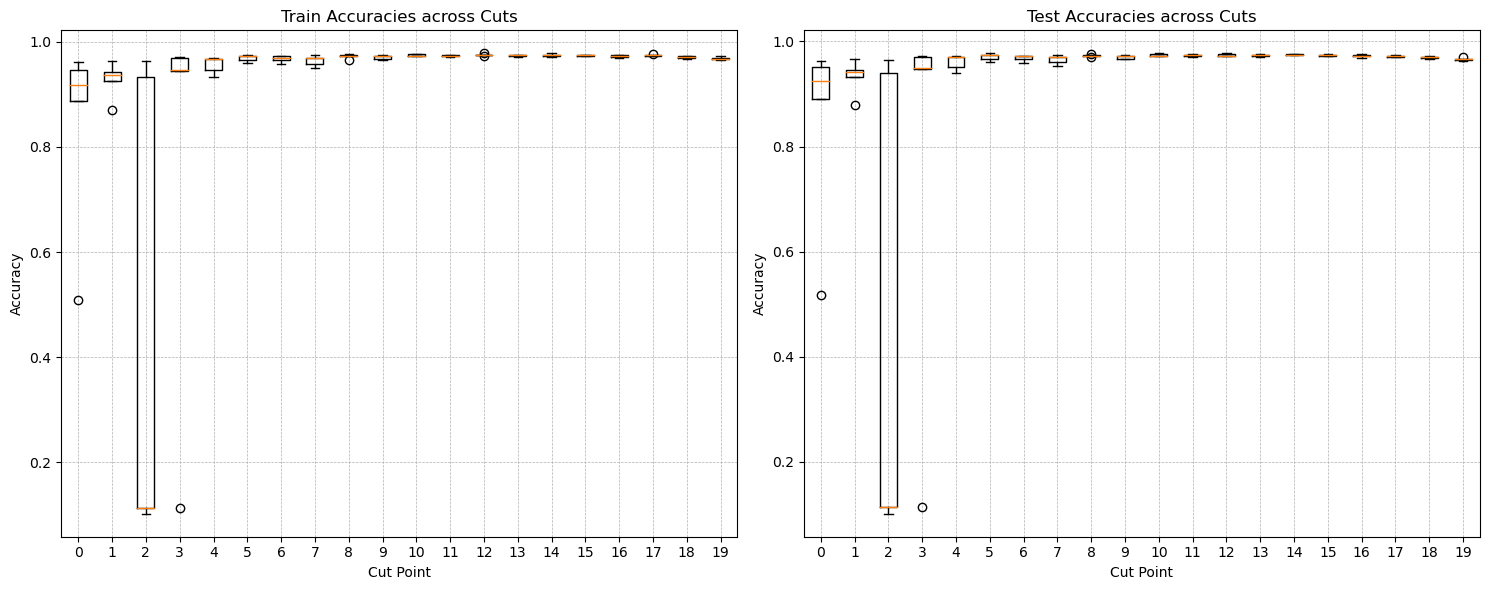

In [40]:
import matplotlib.pyplot as plt

# Initialize lists to store all accuracies for each cut point
train_accuracies = [[] for _ in range(depth)]
test_accuracies = [[] for _ in range(depth)]

# Populate the lists with accuracy values
for cut_models in experiments:
    for cut, model_data in enumerate(cut_models):
        train_accuracies[cut].append(model_data['finetuned_acc'])
        test_accuracies[cut].append(model_data['finetuned_test_acc'])

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot training accuracies
axs[0].boxplot(train_accuracies)
axs[0].set_title('Train Accuracies across Cuts')
axs[0].set_xlabel('Cut Point')
axs[0].set_ylabel('Accuracy')
axs[0].set_xticks(range(1, depth + 1))
axs[0].set_xticklabels(range(depth))
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot test accuracies
axs[1].boxplot(test_accuracies)
axs[1].set_title('Test Accuracies across Cuts')
axs[1].set_xlabel('Cut Point')
axs[1].set_ylabel('Accuracy')
axs[1].set_xticks(range(1, depth + 1))
axs[1].set_xticklabels(range(depth))
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the plots
plt.tight_layout()
plt.show()


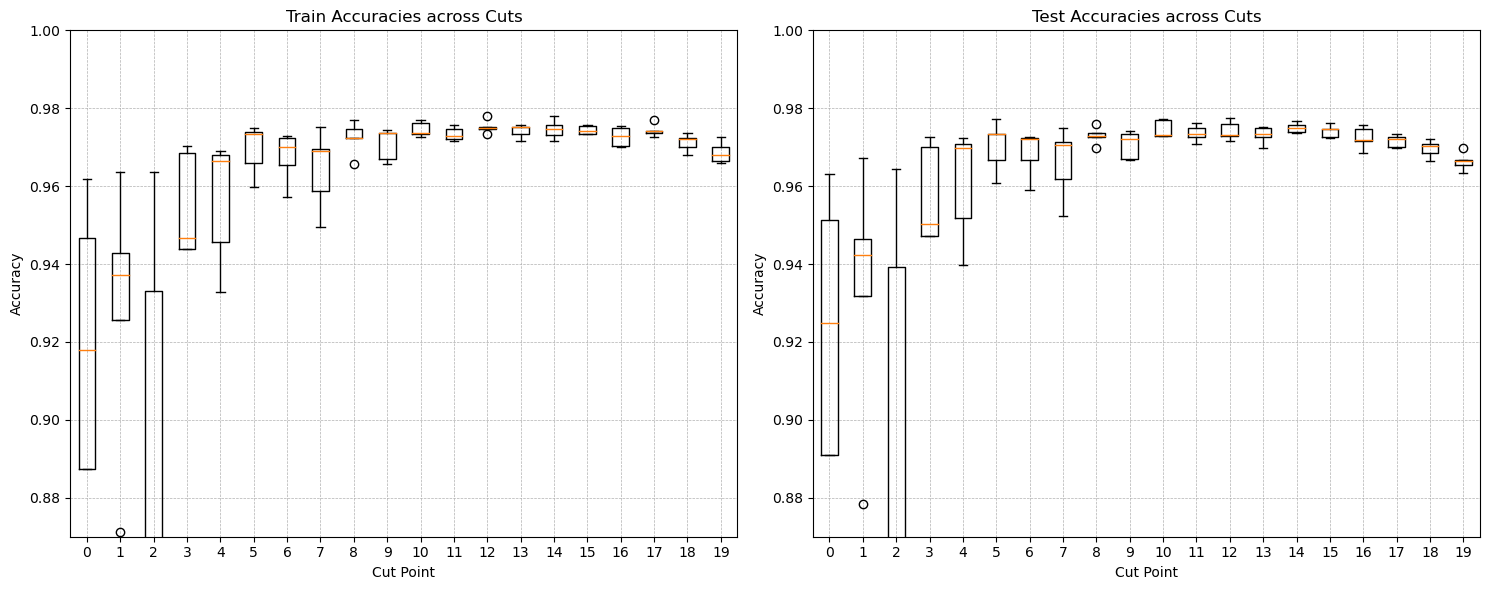

In [42]:
import matplotlib.pyplot as plt

# Initialize lists to store all accuracies for each cut point
train_accuracies = [[] for _ in range(depth)]
test_accuracies = [[] for _ in range(depth)]

# Populate the lists with accuracy values
for cut_models in experiments:
    for cut, model_data in enumerate(cut_models):
        train_accuracies[cut].append(model_data['finetuned_acc'])
        test_accuracies[cut].append(model_data['finetuned_test_acc'])

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot training accuracies
axs[0].boxplot(train_accuracies)
axs[0].set_title('Train Accuracies across Cuts')
axs[0].set_xlabel('Cut Point')
axs[0].set_ylabel('Accuracy')
axs[0].set_xticks(range(1, depth + 1))
axs[0].set_xticklabels(range(depth))
axs[0].set_ylim([0.87, 1.0])  # Set y-axis limits
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot test accuracies
axs[1].boxplot(test_accuracies)
axs[1].set_title('Test Accuracies across Cuts')
axs[1].set_xlabel('Cut Point')
axs[1].set_ylabel('Accuracy')
axs[1].set_xticks(range(1, depth + 1))
axs[1].set_xticklabels(range(depth))
axs[1].set_ylim([0.87, 1.0])  # Set y-axis limits
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the plots
plt.tight_layout()
plt.show()


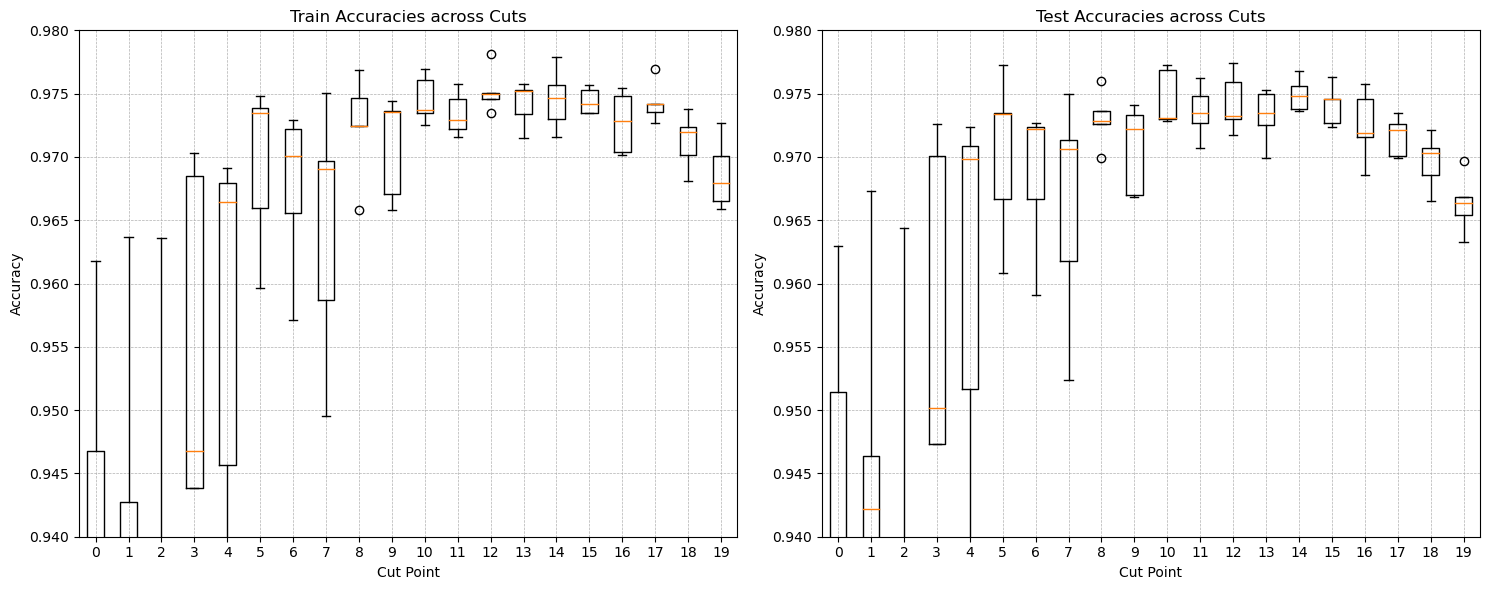

In [43]:
import matplotlib.pyplot as plt

# Initialize lists to store all accuracies for each cut point
train_accuracies = [[] for _ in range(depth)]
test_accuracies = [[] for _ in range(depth)]

# Populate the lists with accuracy values
for cut_models in experiments:
    for cut, model_data in enumerate(cut_models):
        train_accuracies[cut].append(model_data['finetuned_acc'])
        test_accuracies[cut].append(model_data['finetuned_test_acc'])

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot training accuracies
axs[0].boxplot(train_accuracies)
axs[0].set_title('Train Accuracies across Cuts')
axs[0].set_xlabel('Cut Point')
axs[0].set_ylabel('Accuracy')
axs[0].set_xticks(range(1, depth + 1))
axs[0].set_xticklabels(range(depth))
axs[0].set_ylim([0.94, 0.98])  # Set y-axis limits
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot test accuracies
axs[1].boxplot(test_accuracies)
axs[1].set_title('Test Accuracies across Cuts')
axs[1].set_xlabel('Cut Point')
axs[1].set_ylabel('Accuracy')
axs[1].set_xticks(range(1, depth + 1))
axs[1].set_xticklabels(range(depth))
axs[1].set_ylim([0.94, 0.98])  # Set y-axis limits
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the plots
plt.tight_layout()
plt.show()


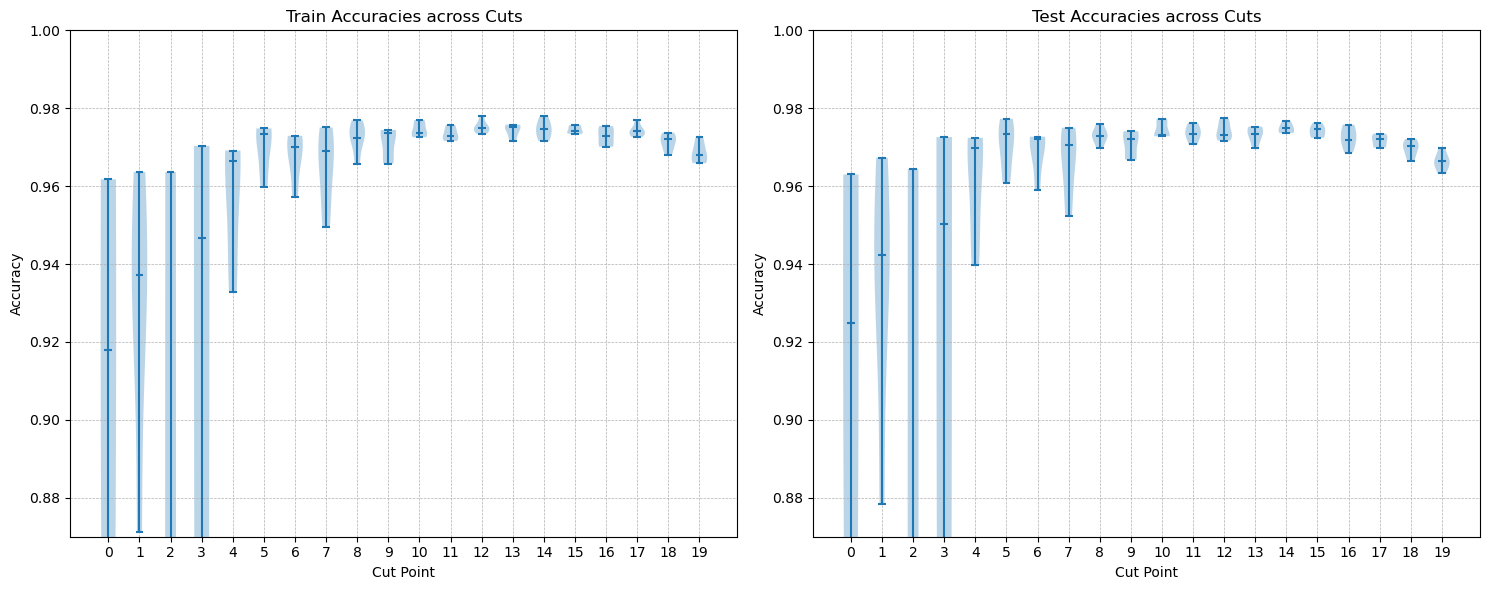

In [47]:
import matplotlib.pyplot as plt

# Initialize lists to store all accuracies for each cut point
train_accuracies = [[] for _ in range(depth)]
test_accuracies = [[] for _ in range(depth)]

# Populate the lists with accuracy values
for cut_models in experiments:
    for cut, model_data in enumerate(cut_models):
        train_accuracies[cut].append(model_data['finetuned_acc'])
        test_accuracies[cut].append(model_data['finetuned_test_acc'])

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot training accuracies using violin plots
axs[0].violinplot(train_accuracies, showmedians=True)
axs[0].set_title('Train Accuracies across Cuts')
axs[0].set_xlabel('Cut Point')
axs[0].set_ylabel('Accuracy')
axs[0].set_xticks(range(1, depth + 1))
axs[0].set_xticklabels(range(depth))
axs[0].set_ylim([0.87, 1.0])  # Set y-axis limits
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot test accuracies using violin plots
axs[1].violinplot(test_accuracies, showmedians=True)
axs[1].set_title('Test Accuracies across Cuts')
axs[1].set_xlabel('Cut Point')
axs[1].set_ylabel('Accuracy')
axs[1].set_xticks(range(1, depth + 1))
axs[1].set_xticklabels(range(depth))
axs[1].set_ylim([0.87, 1.0])  # Set y-axis limits
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)


# Display the plots
plt.tight_layout()
plt.show()


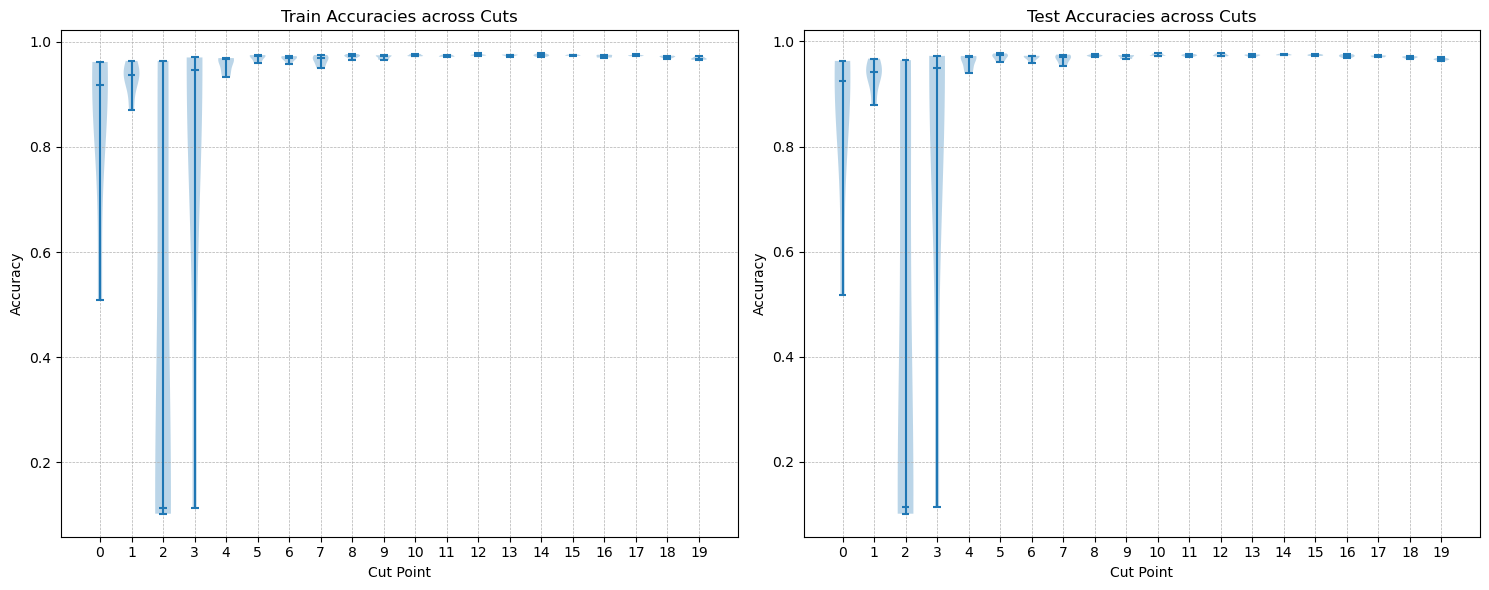

In [45]:
import matplotlib.pyplot as plt

# Initialize lists to store all accuracies for each cut point
train_accuracies = [[] for _ in range(depth)]
test_accuracies = [[] for _ in range(depth)]

# Populate the lists with accuracy values
for cut_models in experiments:
    for cut, model_data in enumerate(cut_models):
        train_accuracies[cut].append(model_data['finetuned_acc'])
        test_accuracies[cut].append(model_data['finetuned_test_acc'])

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot training accuracies using violin plots
axs[0].violinplot(train_accuracies, showmedians=True)
axs[0].set_title('Train Accuracies across Cuts')
axs[0].set_xlabel('Cut Point')
axs[0].set_ylabel('Accuracy')
axs[0].set_xticks(range(1, depth + 1))
axs[0].set_xticklabels(range(depth))
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)


# Plot test accuracies using violin plots
axs[1].violinplot(test_accuracies, showmedians=True)
axs[1].set_title('Test Accuracies across Cuts')
axs[1].set_xlabel('Cut Point')
axs[1].set_ylabel('Accuracy')
axs[1].set_xticks(range(1, depth + 1))
axs[1].set_xticklabels(range(depth))
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)


# Display the plots
plt.tight_layout()
plt.show()


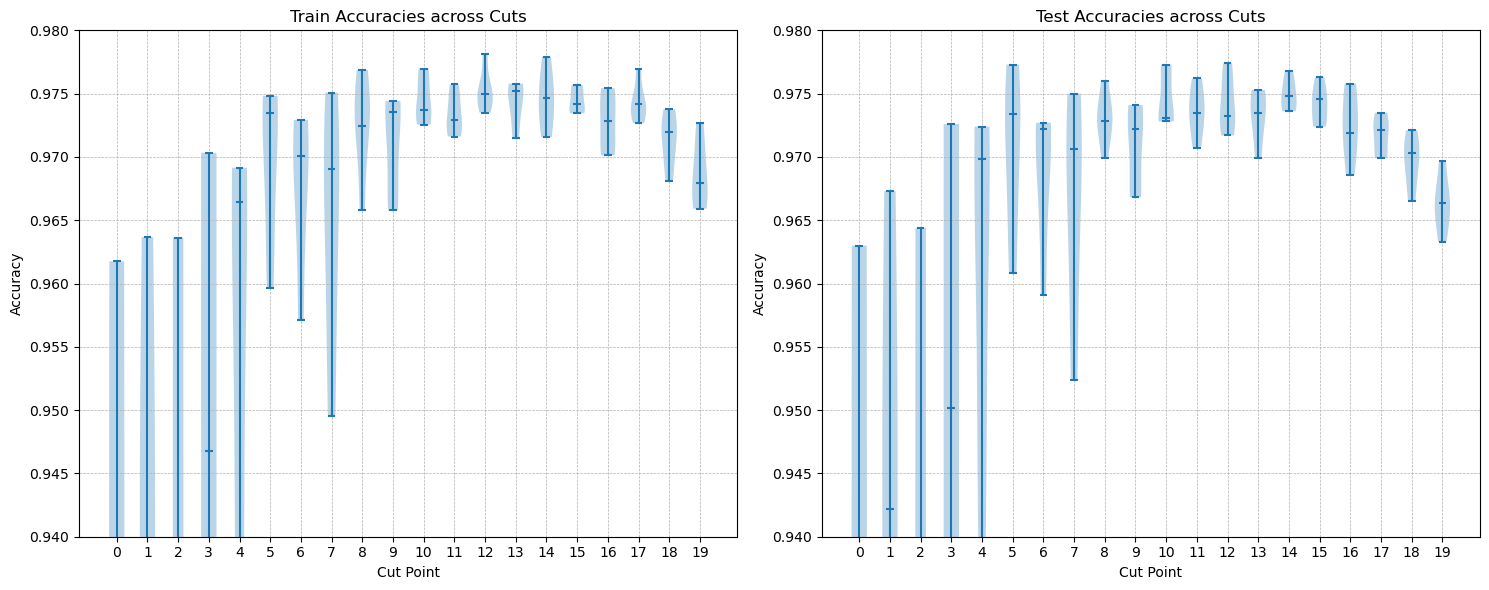

In [46]:
import matplotlib.pyplot as plt

# Initialize lists to store all accuracies for each cut point
train_accuracies = [[] for _ in range(depth)]
test_accuracies = [[] for _ in range(depth)]

# Populate the lists with accuracy values
for cut_models in experiments:
    for cut, model_data in enumerate(cut_models):
        train_accuracies[cut].append(model_data['finetuned_acc'])
        test_accuracies[cut].append(model_data['finetuned_test_acc'])

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot training accuracies using violin plots
axs[0].violinplot(train_accuracies, showmedians=True)
axs[0].set_title('Train Accuracies across Cuts')
axs[0].set_xlabel('Cut Point')
axs[0].set_ylabel('Accuracy')
axs[0].set_xticks(range(1, depth + 1))
axs[0].set_xticklabels(range(depth))
axs[0].set_ylim([0.94, 0.98])
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)


# Plot test accuracies using violin plots
axs[1].violinplot(test_accuracies, showmedians=True)
axs[1].set_title('Test Accuracies across Cuts')
axs[1].set_xlabel('Cut Point')
axs[1].set_ylabel('Accuracy')
axs[1].set_xticks(range(1, depth + 1))
axs[1].set_xticklabels(range(depth))
axs[1].set_ylim([0.94, 0.98])
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)


# Display the plots
plt.tight_layout()
plt.show()


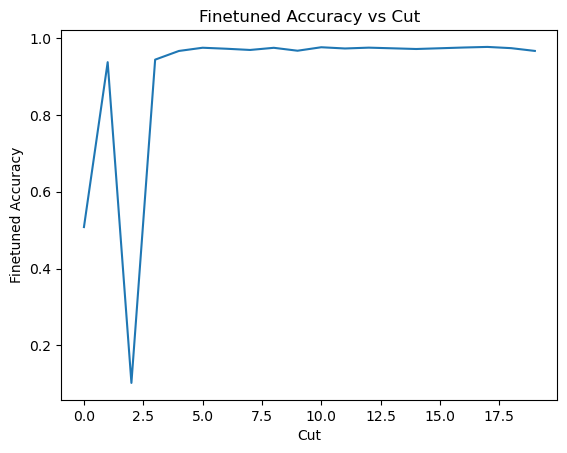

In [38]:
import matplotlib.pyplot as plt

finetuned_accs = [model['finetuned_acc'] for model in cut_models]
cuts = range(len(finetuned_accs))
plt.plot(cuts, finetuned_accs)
plt.xlabel('Cut')
plt.ylabel('Finetuned Accuracy')
plt.title('Finetuned Accuracy vs Cut')
plt.show()

----